In [1]:
import numpy as np
from examples.seismic import TimeAxis, demo_model
from matplotlib import pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as plticker
from examples.seismic.ttipure import PureTtiWaveSolver
from devito import Function, norm, info
from utils import setup_geometry, plotTimeSlices

In [2]:
def tti_setup(shape=(50, 50, 50), spacing=(20.0, 20.0, 20.0), tn=250.0,
              space_order=4, nbl=10, preset='layers-tti',
              **kwargs):

    # Two layer model for true velocity
    model = demo_model(preset, shape=shape, spacing=spacing,
                       space_order=space_order, nbl=nbl, **kwargs)

    # Source and receiver geometries
    geometry = setup_geometry(model, tn)

    return PureTtiWaveSolver(model, geometry, space_order=space_order,
                             **kwargs), model

In [3]:
def run(solver, save=False):

    info("Applying Forward")
    # Whether or not we save the whole time history. We only need the full wavefield
    # with 'save=True' if we compute the gradient without checkpointing, if we use
    # checkpointing, PyRevolve will take care of the time history
    # Define receiver geometry (spread across x, just below surface)
    rec, u, summary = solver.forward(save=save)

    return rec, u

In [4]:
shape = (101, 101, 101)
spacing = (20., 20., 20.)
origin = (0.,0.,0.)
tn = 850.0
nbl = 10

solver, model = tti_setup(shape=shape, spacing=spacing, nbl=nbl, tn=tn, preset='constant-tti')

dt = model.critical_dt

rec, u = run(solver, save=True)

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
Operator `pad_epsilon` ran in 0.01 s
Operator `pad_delta` ran in 0.01 s
Operator `pad_theta` ran in 0.01 s
Operator `pad_phi` ran in 0.01 s
Applying Forward
Operator `ForwardTTI` ran in 0.77 s


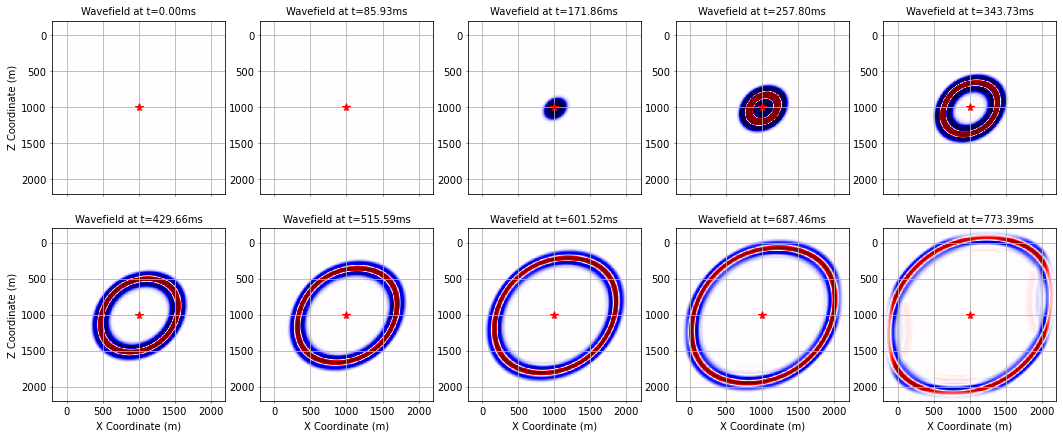

In [7]:
plotTimeSlices (model, u)